In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from bs4 import BeautifulSoup
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = '../data'
SEED = 42 # used to fix random_state

## 1. Data cleaning and preparation

In [3]:
df = pd.read_csv(DATA_DIR + '/raw/IMDB Dataset.csv.zip', compression='zip')

In [4]:
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


First of all, let's split our initial dataset into full training part and test part (which we are going to put aside).

In [6]:
full_train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=SEED)
full_train_df = full_train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [7]:
print(f'Full training dataset shape is {full_train_df.shape}, test part shape is {test_df.shape}.')

Full training dataset shape is (40000, 2), test part shape is (10000, 2).


Now, let's have a look at the full training dataset.

In [8]:
full_train_df.head()

,review,sentiment
0,That's what I kept asking myself during the ma...,negative
1,I did not watch the entire movie. I could not ...,negative
2,A touching love story reminiscent of In the M...,positive
3,This latter-day Fulci schlocker is a totally a...,negative
4,"First of all, I firmly believe that Norwegian ...",negative


In [9]:
full_train_df['sentiment'].value_counts(normalize=True)

negative    0.500975
positive    0.499025
Name: sentiment, dtype: float64

Target variable is pretty good balanced.

In [10]:
full_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [11]:
full_train_df.isnull().sum()

review       0
sentiment    0
dtype: int64

There are no missing values in this part of dataset.

In [12]:
full_train_df.duplicated().sum()

257

As we can see, our full dataset contain 257 duplicate reviews. We can to view them.

In [13]:
reviews = full_train_df['review']
duplicate_reviews = full_train_df[reviews.isin(reviews[reviews.duplicated()])].sort_values("review")
duplicate_reviews.head(10)

,review,sentiment
13617,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
12361,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
37343,"""Three"" is a seriously dumb shipwreck movie. M...",negative
309,"""Three"" is a seriously dumb shipwreck movie. M...",negative
6535,"""Witchery"" might just be the most incoherent a...",negative
13962,"""Witchery"" might just be the most incoherent a...",negative
20171,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative
34896,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative
14629,"**SPOILERS** I rented ""Tesis"" (or ""Thesis"" in ...",negative
32733,"**SPOILERS** I rented ""Tesis"" (or ""Thesis"" in ...",negative


In future, it would be better to drop it from our training dataset.

Now, it's time to prepare our dataset. What we are going to do with our text corpus? 
* Our reviews contains HTML tags after scrapping, so we need to drop them out.
* We should replace word contractions in the texts with their original forms.
* hen we need to delete other special characters, punctuation marks and URLs contained in our text corpus.
* We are also going to remove stopwords. Stopwords are the English words which do not add sufficient meaning to a sentence (such as *the*, *is*, *are*). They can safely be ignored without sacrificing the meaning of the sentence. You can read [more](https://pythonspot.com/nltk-stop-words/) about it.
* And finally, we need to apply text normalization. In our case, it will be a word [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation). Lemmatization is a technique of finding the lemma of a word depending on its meaning and context.

We will use Beautiful Soup, NLTK and scikit-learn libraries for such purposes. [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) is a useful tool for data scrapping and [NLTK](https://www.nltk.org/) is a well-known texts processing library.

Also below I have identified several functions that will help us in text processing.

In [14]:
stop_words = stopwords.words('english')

In [15]:
short_form_mappings = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                       "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                       "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                       "she's": "she is", "should've": "should have", "shouldn't": "should not",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                       "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                       "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                       "we're": "we are", "we've": "we have", "weren't": "were not", 
                       "what'll": "what will", "what'll've": "what will have","what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
                       "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have" }

In [16]:
with open(DATA_DIR + '/external/mappings.json', 'w') as f_out: 
    json.dump(short_form_mappings, f_out)

In [17]:
lemmatizer  = WordNetLemmatizer()

In [18]:
def remove_html_tags(text: str) -> str:
    """ Throws away HTML tags from text """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_emoji(text: str) -> str:
    """ Removes all special symbols from the text """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_URLs(text: str) -> str:
    """ Removes URL's from the text """
    return re.sub(r'http\S+', '', text)

def remove_punctuations(text: str) -> str:
    """ Removes punctuation signs """
    return ''.join(
        [word.lower() for word in text if word not in string.punctuation]
    )

def remove_stopwords(text: str) -> str:
    """ Removes stopwords """
    return ' '.join(
        [word for word in text.split() if word not in stop_words and word.isalpha()]
    )

def add_space(text: str) -> str:
    """ Adds space after dot symbol """
    return re.sub(r'\.(?=\S)', '. ', text)

def process_mappings(text: str) -> str:
    """ Replaces word contractions with their original form """
    return ' '.join(
        [short_form_mappings[word] if word in short_form_mappings else word for word in text.split(" ")]
    )

def apply_lemmatizer(text: str) -> str:
    """ Applies WordNetLemmatizer to the text """
    return ' '.join(
        [lemmatizer.lemmatize(word) for word in text.split() if word.isalpha()]
    )

In [19]:
def process_text(text: str, lemmatize: bool = True) -> str:
    text = remove_html_tags(text)
    text = process_mappings(text)
    text = remove_emoji(text)
    text = add_space(text)
    text = remove_URLs(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    
    if lemmatize:
        text = apply_lemmatizer(text)
    
    return text

We will apply text processing procedure both to full training and testing datasets.

In [20]:
full_train_df_copy = full_train_df.copy()

In [21]:
%%time
full_train_df['review'] = full_train_df['review'].apply(process_text, lemmatize = True)

Wall time: 1min 57s


In [22]:
# Simple label encoding
full_train_df['sentiment'] = full_train_df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

In [23]:
full_train_df.head()

,review,sentiment
0,thats kept asking many fight screaming match s...,0
1,watch entire movie could watch entire movie st...,0
2,touching love story reminiscent mood love draw...,1
3,latterday fulci schlocker totally abysmal conc...,0
4,first firmly believe norwegian movie continual...,0


In [24]:
%%time
test_df['review'] = test_df['review'].apply(process_text, lemmatize = True)

Wall time: 28.4 s


In [25]:
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
test_df.head()

,review,sentiment
0,really liked summerslam due look arena curtain...,1
1,many television show appeal quite many differe...,1
2,film quickly get major chase scene ever increa...,0
3,jane austen would definitely approve onegwynet...,1
4,expectation somewhat high went see movie thoug...,0


We will save the processed datasets for the future reuse.

In [26]:
full_train_df.to_csv(DATA_DIR + '/processed/full_train.csv')
test_df.to_csv(DATA_DIR + '/processed/test.csv')

## 2. Exploratory data analysis (EDA)

Now let's get down to EDA. We are going to plot target label distribution at first.

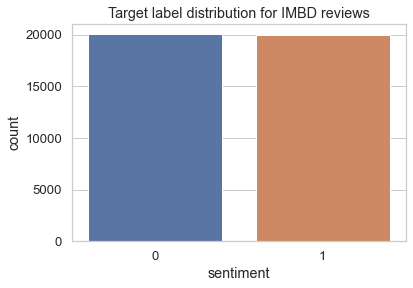

In [27]:
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(full_train_df['sentiment'])
plt.title('Target label distribution for IMBD reviews')
plt.show()

As we mentioned before, target column looks good enought.

Let's calculate some word statistics now, such as number of characters and words in texts.

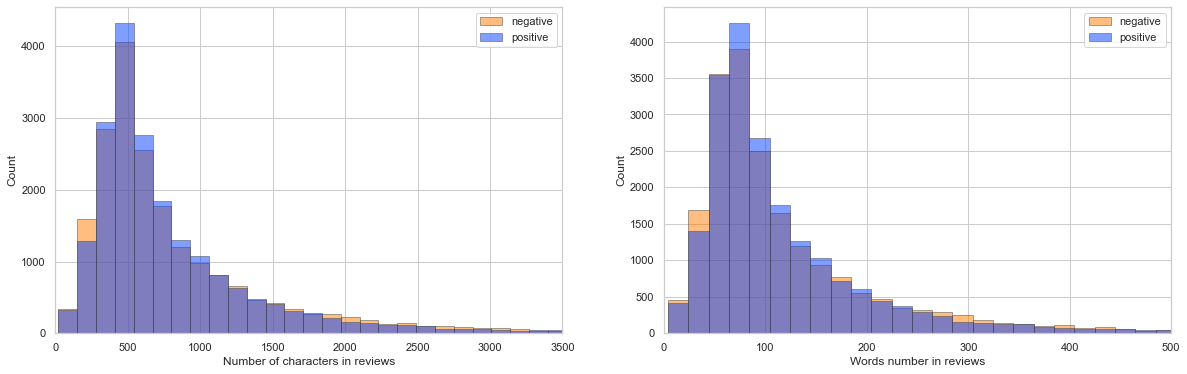

In [28]:
sns.set(style = "whitegrid", palette=sns.color_palette('bright'))
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(
    data=full_train_df,
    x=full_train_df['review'].str.len(), 
    hue="sentiment",
    bins=70,
    edgecolor=".3",
    linewidth=.5,
    ax=ax[0],
)
ax[0].set_xlabel('Number of characters in reviews')
ax[0].set_xlim(0, 3500)
ax[0].legend(['negative', 'positive'])

sns.histplot(
    data=full_train_df,
    x=full_train_df['review'].str.split().map(lambda x: len(x)), 
    hue="sentiment",
    bins=70,
    edgecolor=".3",
    linewidth=.5,
    ax=ax[1],
)
ax[1].set_xlabel('Words number in reviews')
ax[1].set_xlim(0, 500)
ax[1].legend(['negative', 'positive'])

plt.show()

Seems like we have normal distributions with heavy tails on the right. Both diagrams looks similar.

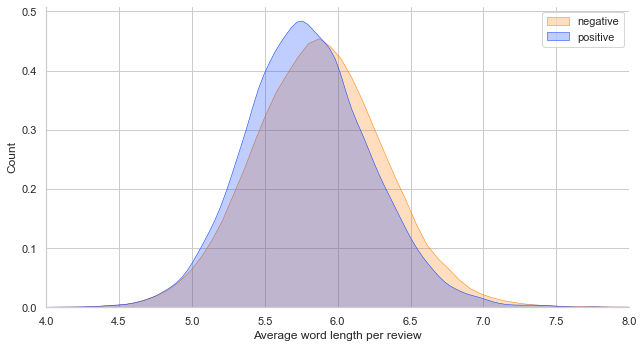

In [29]:
chart = sns.displot(
    data=full_train_df,
    x=full_train_df['review'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), 
    hue="sentiment",
    kind='kde',
    fill=True,
    linewidth=.5, 
    height=5, 
    aspect=1.8, 
    palette=sns.color_palette('bright')[:2],
    legend=False
)
chart.set_axis_labels('Average word length per review', 'Count')
plt.xlim(4, 8)
plt.legend(['negative', 'positive']);

Both curves of the Average word length also have a normal distributions. They are almost symmetrical on both sides of the mean. And only the values of their medians (means) are slightly different.

Next, we will get the most popular words and word sequences ([n-grams](https://en.wikipedia.org/wiki/N-gram)) for each group. In our case we will carry out unigrams, bigrams and trigrams analysis.

In [30]:
def get_corpus(texts: pd.Series) -> list:
    words = []
    for text in texts:
        for word in text.split():
            words.append(word.strip())
    return words
corpus = get_corpus(full_train_df['review'])
corpus[:5]

['thats', 'kept', 'asking', 'many', 'fight']

In [31]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common, columns = ['word', 'count'])
most_common

,word,count
0,movie,80959
1,film,73338
2,one,43232
3,like,32008
4,time,24270
5,would,24236
6,good,23179
7,character,22356
8,story,19885
9,even,19652


In [32]:
def get_most_common_ngrams(corpus: pd.Series, n: int, size: int) -> list:
    """ Returns most commom word n-grams of corpus """
    cv = CountVectorizer(ngram_range=(size, size))
    bag_of_words = cv.fit_transform(corpus) # sparse matrix of CountVectorizer
    words_count = bag_of_words.sum(axis=0) # total number of words
    words_count = np.array(words_count)[0].tolist() # convert to list
    words_freq = [(word, words_count[idx]) for word, idx in cv.vocabulary_.items()] # get word frequency for word location in CountVectorizer
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) # key is used to perform sorting using word_freqency 
    return words_freq[:n]

In [33]:
positive_reviews = full_train_df[full_train_df.sentiment == 1]['review']
negative_reviews = full_train_df[full_train_df.sentiment == 0]['review']

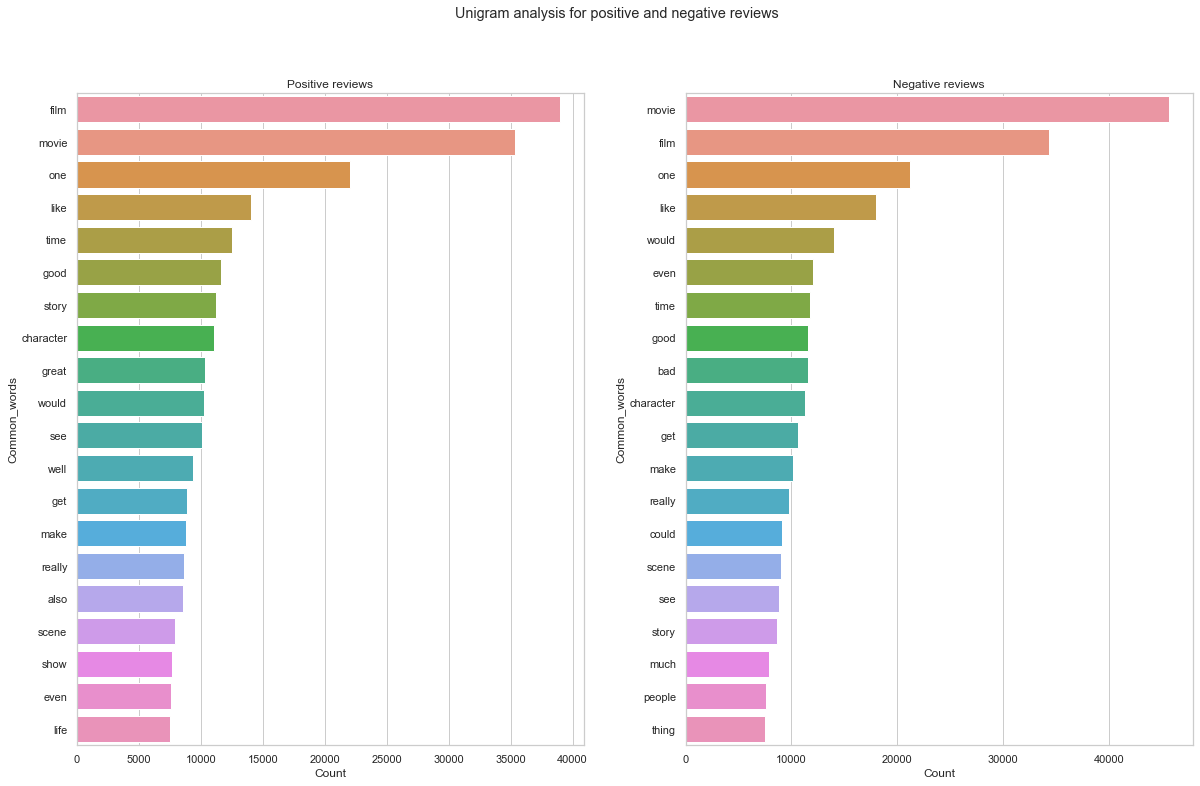

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
positive_unigrams = get_most_common_ngrams(positive_reviews, 20, 1)
plot_positive = pd.DataFrame(dict(positive_unigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_positive, x='Count', y='Common_words', orient='h', ax=ax[0])
ax[0].set_title('Positive reviews')

negative_unigrams = get_most_common_ngrams(negative_reviews, 20, 1)
plot_negative = pd.DataFrame(dict(negative_unigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_negative, x='Count', y='Common_words', orient='h', ax=ax[1])
ax[1].set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')

plt.show()

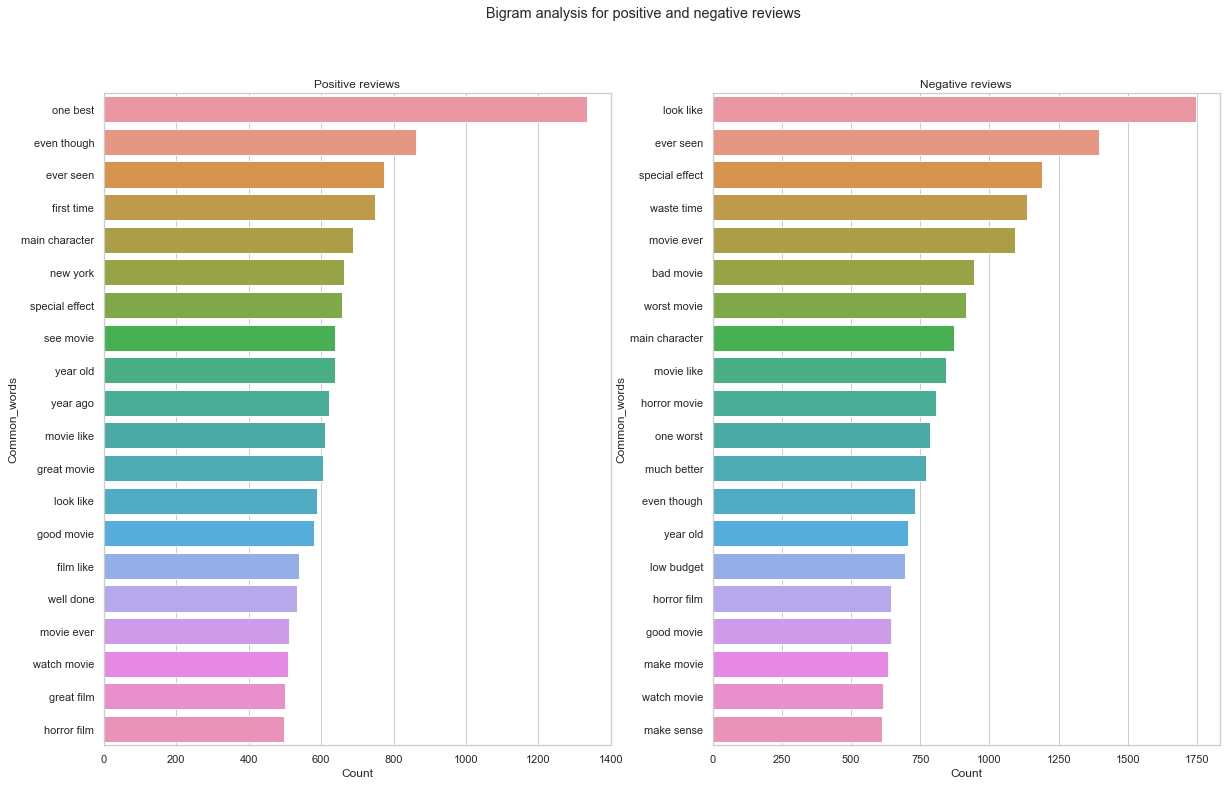

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
positive_bigrams = get_most_common_ngrams(positive_reviews, 20, 2)
plot_positive = pd.DataFrame(dict(positive_bigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_positive, x='Count', y='Common_words', orient='h', ax=ax[0])
ax[0].set_title('Positive reviews')

negative_bigrams = get_most_common_ngrams(negative_reviews, 20, 2)
plot_negative = pd.DataFrame(dict(negative_bigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_negative, x='Count', y='Common_words', orient='h', ax=ax[1])
ax[1].set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')

plt.show()

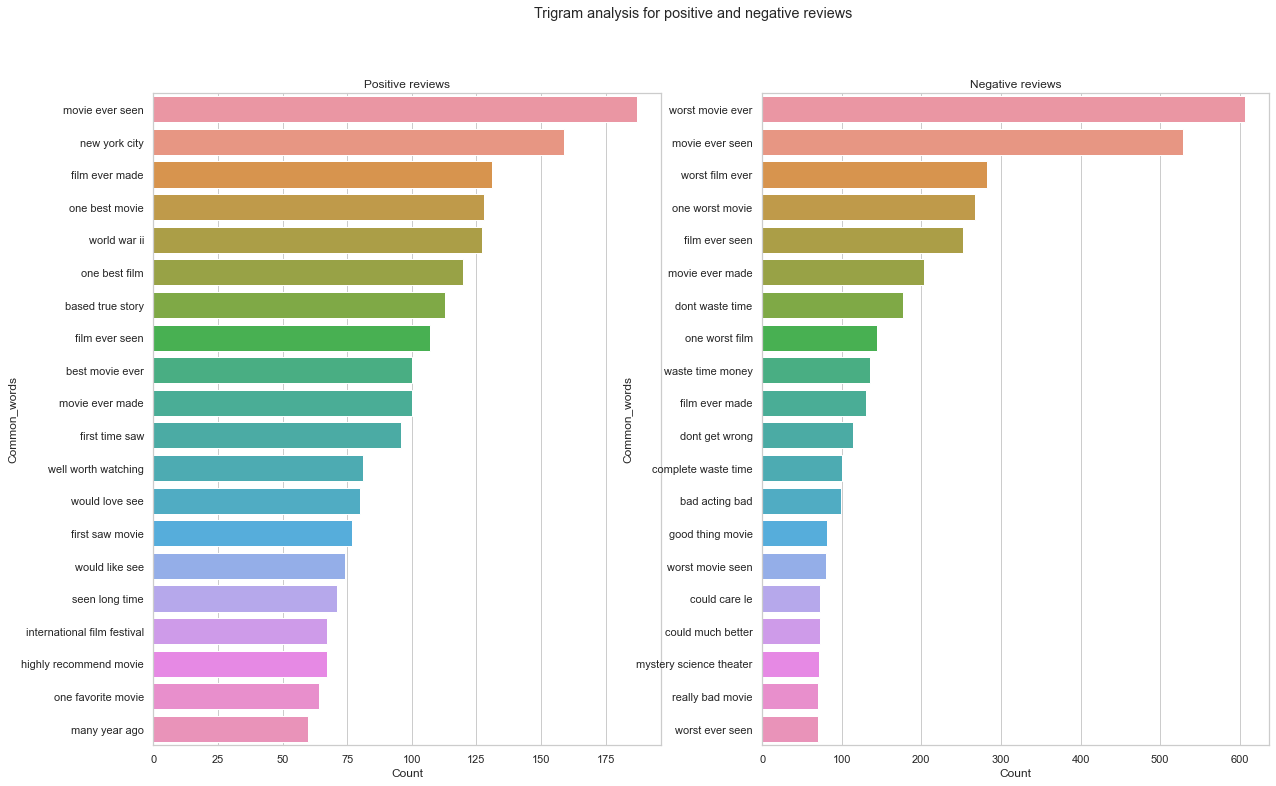

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
positive_trigrams = get_most_common_ngrams(positive_reviews, 20, 3)
plot_positive = pd.DataFrame(dict(positive_trigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_positive, x='Count', y='Common_words', orient='h', ax=ax[0])
ax[0].set_title('Positive reviews')

negative_trigrams = get_most_common_ngrams(negative_reviews, 20, 3)
plot_negative = pd.DataFrame(dict(negative_trigrams).items(), columns = ['Common_words' , 'Count'])
sns.barplot(data=plot_negative, x='Count', y='Common_words', orient='h', ax=ax[1])
ax[1].set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')

plt.show()

So what does the n-gram analysis show us?
* In case of unigrams, we have top-20 lists that are quite close to each other. Of course, we can find some words in these lists that could be serve as a marker of each group (like *great* or *bad*). But without any context, it doesn't really make sense.
* Unlike unigrams, bigrams and trigrams are more informative. And they can definitely characterize the positive or negative reviews. Try to compare *well done*, *great film*, *one best movie*, *highly recommend movie* with *bad movie*, *worst movie ever* or *complete waste time*.

And finally, we can build Wordclouds for positive and negative reviews. It's a visual representation of text data, where the importance of each word is shown with font size or color.

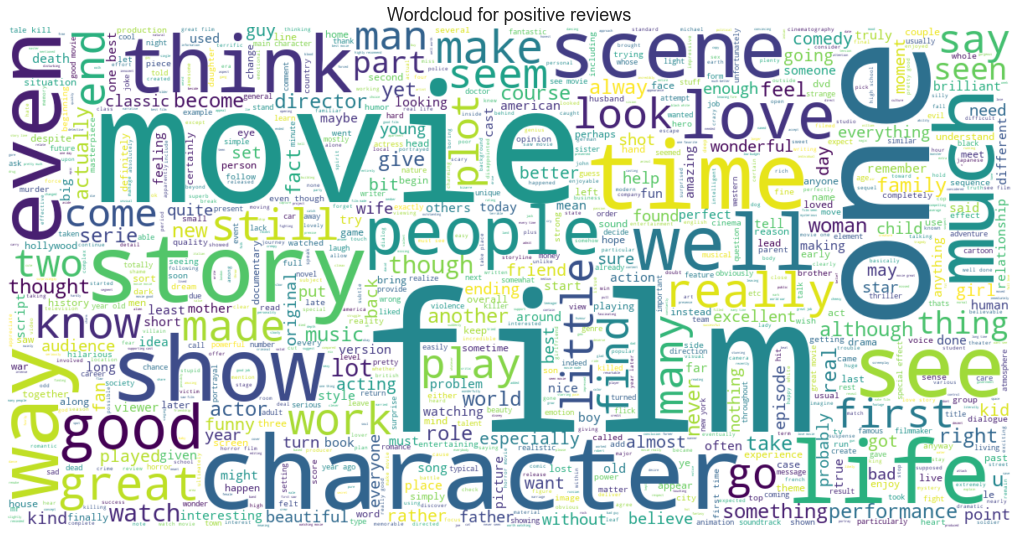

In [37]:
plt.figure(figsize = (18, 18))
word_cloud = WordCloud(max_words = 1000, width = 1200, height = 600, background_color="white").generate(' '.join(positive_reviews))
plt.imshow(word_cloud , interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for positive reviews',fontsize = 18)
plt.show()

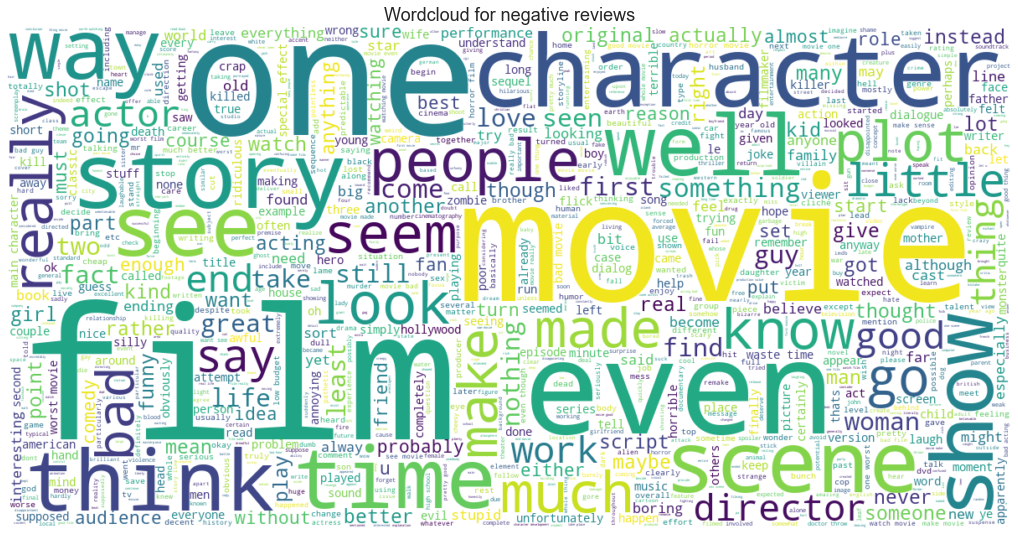

In [38]:
plt.figure(figsize = (18, 18))
word_cloud = WordCloud(max_words = 1000, width = 1200, height = 600, background_color="white").generate(' '.join(negative_reviews))
plt.imshow(word_cloud , interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for negative reviews',fontsize = 18)
plt.show()

We can see that there are a number of common words in both clouds.

In the next notebook we will start training models and select the best one.